# This network is to perform embedding on the network

# Table of contents
## <a href='#Load-data'>Load data</a>
## <a href='#Network-embedding'>Network embedding</a>
## <a href='#See-where-the-DEGs-are-on-the-umap'>DEGs on network embedding</a>
## <a href='#Color-code-the-network-embedding-by-the-community-in-the-network'>Color code network embedding by the network community</a>

# Load data

In [128]:
import pandas as pd
import seaborn as sns
import numpy as np
from node2vec import Node2Vec
import networkx as nx
import umap
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
tom_df = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\Kapoor_TOM.csv', index_col = 0)

In [4]:
tom_scaled_df = -np.log(tom_df)

In [4]:
tom_scaled_df.head(3)

,ENSG00000227232,ENSG00000237683,ENSG00000241860,ENSG00000228463,ENSG00000225972,ENSG00000225630,ENSG00000237973,ENSG00000229344,ENSG00000248527,ENSG00000198744,...,ENSG00000226555,ENSG00000176728,ENSG00000217896,ENSG00000185275,ENSG00000131002,ENSG00000267793,ENSG00000260197,ENSG00000012817,ENSG00000229236,ENSG00000198692
ENSG00000227232,-0.000000,10.795362,10.424995,12.172133,9.524720,10.161862,10.670124,8.993186,9.776535,10.531492,...,12.612150,12.535343,12.697890,11.203138,12.589825,12.929011,12.790372,12.404996,12.555441,12.516806
ENSG00000237683,10.795362,-0.000000,7.596272,11.569108,11.204437,12.318667,12.220523,10.698395,10.958686,12.565159,...,12.962245,13.313519,12.637286,12.194893,13.416790,13.163594,13.253465,13.424748,13.133533,13.675610
ENSG00000241860,10.424995,7.596272,-0.000000,8.250425,11.280891,11.623912,12.646245,11.594074,11.385809,11.783875,...,11.694646,11.690060,11.734194,11.673423,11.714257,11.766532,11.715652,11.732658,11.694039,11.728269


# Network embedding

In [5]:
def subset_network(network_df, weight_min, weight_max):
    subset = network_df[(network_df > weight_min) & (network_df < weight_max)]
    # remove columns if the entire column is nan, same with rows
    subset.dropna(how = 'all', inplace = True)
    subset.dropna(axis = 1, how = 'all', inplace = True)
    print('Number of nodes:',len(subset))
    subset_adj = subset.stack().dropna().reset_index() # convert from wide to long to remove na
    return subset_adj

In [6]:
def network_embedding(adjacency_matrix, walk_length, num_walks, window):
    G = nx.convert_matrix.from_pandas_edgelist(adjacency_matrix, source = 'level_0', target = 'level_1')
    node2vec = Node2Vec(G, dimensions=100, walk_length=walk_length, num_walks=num_walks)
    model = node2vec.fit(window = window, min_count=1, workers = 4)
    emb_df = pd.DataFrame(np.asarray(model.wv.vectors), index = G.nodes)
    return emb_df

In [7]:
# subset to get ~10k nodes for embedding
tom_subset_adj = subset_network(tom_scaled_df, 0.01, 3.3)

Number of nodes: 10560


In [8]:
G = nx.convert_matrix.from_pandas_edgelist(tom_subset_adj, source = 'level_0', target = 'level_1')

In [9]:
emb_tom = network_embedding(tom_subset_adj, 20, 30, 10)

Generating walks (CPU: 1): 100%|██████████████████████████████████| 30/30 [09:24<00:00, 18.80s/it]


In [54]:
emb_tom.to_csv(r'C:\Users\bbche\Documents\GitRepos\assist\data\embedded_tom_10k_nodes.csv')

# compare network weights and embedding similarity

In [15]:
umap_emb = umap.UMAP(n_neighbors = 8, min_dist = 0.3, random_state=42).fit_transform(emb_tom)
umap_df = pd.DataFrame(umap_emb, index = emb_tom.index)

In [12]:
# get the top 10 nodes that share large weights with ENSG00000233864 as an example
similar_to_64 = tom_subset_adj[tom_subset_adj.level_0 == 'ENSG00000233864'].sort_values(by = 0)['level_1'][:10].tolist()

In [13]:
similar_to_64.append('ENSG00000233864')

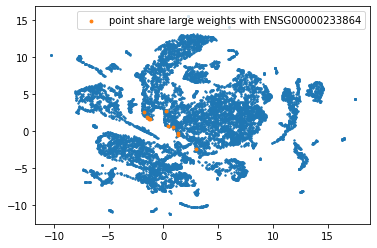

In [16]:
# plot umap and show 10 nodes that share large weights with ENSG00000233864 to see how they distribute on the umap
plt.scatter(umap_emb[:, 0], umap_emb[:, 1], s = 2)
plt.scatter(umap_df.loc[umap_df.index.isin(similar_to_64), 0], umap_df.loc[umap_df.index.isin(similar_to_64), 1], s = 8, 
            label = 'point share large weights with ENSG00000233864')
plt.legend()

# Color code the network embedding by the log2FC

In [17]:
deseq = pd.read_excel(r'G:\Shared drives\NIAAA_ASSIST\Data\deseq.alc.vs.control.age.rin.batch.gender.PMI.corrected.w.prot.coding.gene.name.xlsx')

In [132]:
umap_deseq_df = pd.merge(umap_df, deseq, left_on = 'id', right_on = 'id')

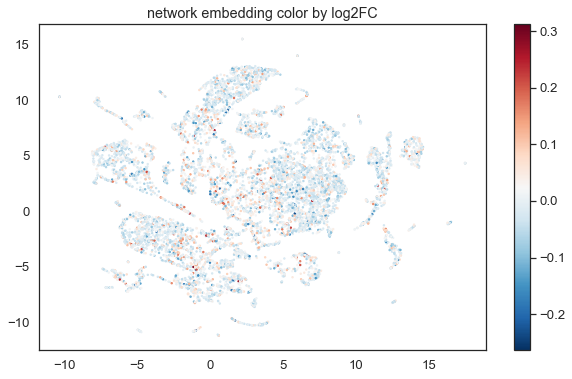

In [158]:
sns.set(rc={'figure.figsize':(10,6)})
sns.set(font_scale = 1.2)
sns.set_style('white')
cmap = sns.color_palette('RdBu_r', as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(umap_deseq_df.loc[:,0], umap_deseq_df.loc[:,1], c=umap_deseq_df.loc[:,'log2FoldChange'], s=2, cmap=cmap)
f.colorbar(points)
plt.title('network embedding color by log2FC');

In [117]:
communities = list(greedy_modularity_communities(G, weight = 'weight'))

In [119]:
# convert the community list to dfs
community_dfs = []
for i, c in enumerate(communities):
    community_df = pd.DataFrame({'id':c})
    community_df['community'] = i+1
    community_dfs.append(community_df)
community_dfs = pd.concat(community_dfs)   

In [89]:
# join community label to umap df
umap_df = pd.merge(umap_df, community_dfs, left_index = True, right_on = 'id')

# Color code the network embedding by the community in the network

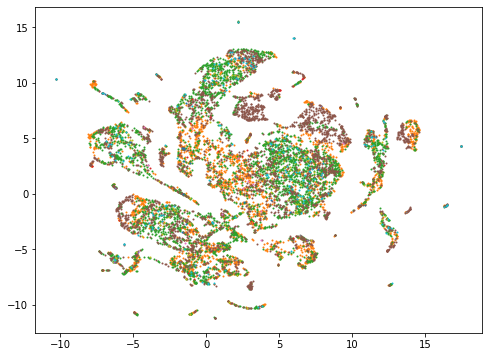

In [125]:
plt.figure(figsize = (8,6))
for c in umap_df.community.unique()[:30]:
    subset = umap_df[umap_df.community == c]
    plt.scatter(subset.iloc[:, 0], subset.loc[:, 1], s = 1)

## The colors don't align that well with the clusters in the network embedding. Probably need to try different embedding parameters. 